In [28]:
import torch
import matplotlib.pyplot as plt
from simple_truss import Truss
import math

torch.set_default_dtype(torch.double)


# Sample truss

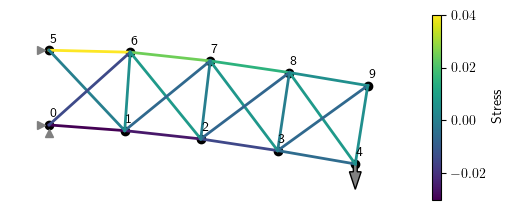

In [29]:
n1 = torch.linspace(0.0, 4.0, 5)
n2 = torch.linspace(0.0, 1.0, 2)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

elements = torch.tensor(
    [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 4],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 9],
        [1, 5],
        [0, 6],
        [2, 6],
        [1, 7],
        [3, 7],
        [2, 8],
        [4, 8],
        [3, 9],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9],
    ]
)

forces = torch.zeros_like(nodes)
forces[4, 1] = -0.1
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0, 0] = True
constraints[0, 1] = True
constraints[5, 0] = True
a = 10 * torch.ones((len(elements)))

truss_sample = Truss(nodes, elements, forces, constraints, E=1.0)
u, f, sigma = truss_sample.solve(a)
truss_sample.plot(u=u, sigma=sigma)
plt.savefig("figures/truss_sample_solved.pdf", bbox_inches="tight")
plt.show()


## Single truss element

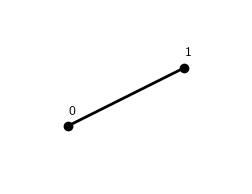

In [30]:
nodes = torch.tensor([[0.0, 0.0], [1.0, 0.5]])
elements = torch.tensor([[0, 1]])
forces = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)

plt.figure(figsize=(3, 3))
single_truss = Truss(nodes, elements, forces, constraints, E=1.0)
single_truss.plot()
plt.savefig("figures/single_truss.pdf", bbox_inches="tight")
plt.show()


## Three bar truss

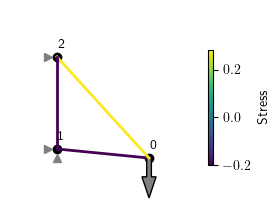

In [31]:
nodes = torch.tensor([[1.0, 0.0], [0.0, 0.0], [0.0, 1.0]])
elements = torch.tensor([[0, 1], [0, 2], [1, 2]])
forces = torch.zeros_like(nodes)
forces[0, 1] = -0.2
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[1, 0] = True
constraints[1, 1] = True
constraints[2, 0] = True
a = torch.ones((len(elements)))

plt.figure(figsize=(3, 3))
three_bar_truss = Truss(nodes, elements, forces, constraints, E=10.0)
u, f, sigma = three_bar_truss.solve(a)
three_bar_truss.plot(u=u, sigma=sigma)
plt.savefig("figures/three_bar_truss_solved.pdf", bbox_inches="tight", transparent=True)
plt.show()


## The optimization

In [32]:
def newton(grad, mu_init, max_iter=10, tol=0.0001):
    # Newton's method to find root of grad (few iterations, if succesfull)
    mu = torch.tensor([mu_init], requires_grad=True)
    i = 0
    while torch.abs(grad(mu)) > tol:
        if i > max_iter:
            raise Exception(f"Newton solver did not converge in {max_iter} iterations.")
        gradgrad = torch.autograd.grad(grad(mu).sum(), mu)[0]
        mu.data -= grad(mu) / gradgrad
        mu.data = torch.maximum(mu.data, torch.tensor([0.0]))
        i += 1
    return mu.data


def bisection(grad, a, b, max_iter=50, tol=1e-10):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if grad(a) * grad(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c


def optimize(truss, a_0, a_min, a_max, V_0, iter=10, s=0.7):
    a = [a_0]
    L = []
    l = truss.element_lengths()

    # Check if there is a feasible solution before starting iteration
    if torch.inner(a_min, l) > V_0:
        raise Exception("x_min is not compatible with V_0.")

    # Iterate solutions
    for k in range(iter):
        # Solve the truss problem at point x_k
        u_k, f_k, sigma_k = truss.solve(a[k])

        # Get strain energy of all truss elements for the given displacement
        w_k = truss.element_strain_energies(u_k)

        # Compute lower asymptote
        if k > 1:
            L_k = torch.zeros_like(L[k - 1])
            for j in range(len(L_k)):
                if (a[k][j] - a[k - 1][j]) * (a[k - 1][j] - a[k - 2][j]) < 0.0:
                    L_k[j] = a[k][j] - s * (a[k - 1][j] - L[k - 1][j])
                else:
                    L_k[j] = a[k][j] - 1 / math.sqrt(s) * (a[k - 1][j] - L[k - 1][j])
            L.append(L_k)
        else:
            L.append(a[k] - s * (a_max - a_min))

        # Compute lower move limit in this step
        a_min_k = torch.maximum(a_min, 0.9 * L[k] + 0.1 * a[k])

        # Analytical solution
        def x_star(mu):
            EPS = 1e-15  # Trick to prevent division by zero
            a_hat = L[k] + torch.sqrt(
                (2 * w_k * (L[k] - a[k]) ** 2 + EPS) / (mu * l + EPS)
            )
            return torch.maximum(torch.minimum(a_hat, a_max), a_min_k)

        # Analytical gradient
        def grad(mu):
            return torch.dot(x_star(mu), l) - V_0

        # Solve dual problem
        # mu_star = newton(grad, 1.0)
        mu_star = bisection(grad, 0.0, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        # Compute current optimal point with dual solution
        a.append(x_star(mu_star))

    return a


## Optimization of the three bar truss

Iteration k=0 - Compliance: 0.07790
Iteration k=1 - Compliance: 0.04519
Iteration k=2 - Compliance: 0.03783
Iteration k=3 - Compliance: 0.03750
Iteration k=4 - Compliance: 0.03749
Iteration k=5 - Compliance: 0.03749
Iteration k=6 - Compliance: 0.03749
Iteration k=7 - Compliance: 0.03749
Iteration k=8 - Compliance: 0.03749
Iteration k=9 - Compliance: 0.03749


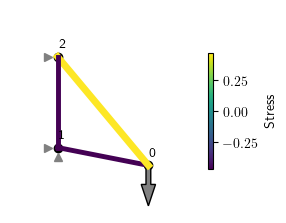

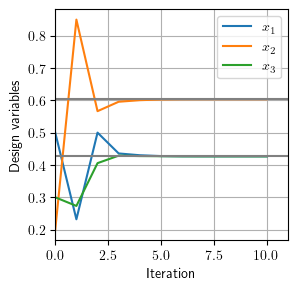

In [33]:
# Limits on design variables
a_0 = torch.tensor([0.5, 0.2, 0.3])
a_min = 0.1 * torch.ones_like(a_0)
a_max = 1.0 * torch.ones_like(a_0)
# Compute volume restriction
l = three_bar_truss.element_lengths()
V0 = 0.5 * torch.inner(a_max, l)

a_opt = optimize(three_bar_truss, a_0, a_min, a_max, V0)
u, f, sigma = three_bar_truss.solve(a_opt[-1])

plt.figure(figsize=(3, 3))
three_bar_truss.plot(u=u, sigma=sigma, a=a_opt[-1])
plt.savefig(
    "figures/three_bar_truss_optimized.pdf", transparent=True, bbox_inches="tight"
)
plt.show()

plt.rcParams["text.usetex"] = True

l = three_bar_truss.element_lengths()
plt.figure(figsize=(3, 3))
plt.plot(range(len(a_opt)), torch.stack(a_opt))
plt.axhline(0.25 * V0 , color="gray")
plt.axhline(0.3535 * V0, color="gray")
plt.legend(["$x_1$", "$x_2$", "$x_3$"])
plt.xlabel("Iteration")
plt.ylabel("Design variables")
plt.xlim([0, len(a_opt)])
plt.grid()
plt.savefig(
    "figures/three_bar_truss_variables.pdf", transparent=True, bbox_inches="tight"
)
plt.show()


## Optimization of the sample truss

Iteration k=0 - Compliance: 0.10004
Iteration k=1 - Compliance: 0.03018
Iteration k=2 - Compliance: 0.03039
Iteration k=3 - Compliance: 0.02945
Iteration k=4 - Compliance: 0.02928
Iteration k=5 - Compliance: 0.02899
Iteration k=6 - Compliance: 0.02892
Iteration k=7 - Compliance: 0.02888
Iteration k=8 - Compliance: 0.02884
Iteration k=9 - Compliance: 0.02882
Iteration k=10 - Compliance: 0.02882
Iteration k=11 - Compliance: 0.02882
Iteration k=12 - Compliance: 0.02882
Iteration k=13 - Compliance: 0.02882
Iteration k=14 - Compliance: 0.02882
Iteration k=15 - Compliance: 0.02882
Iteration k=16 - Compliance: 0.02882
Iteration k=17 - Compliance: 0.02882
Iteration k=18 - Compliance: 0.02882
Iteration k=19 - Compliance: 0.02882
Iteration k=20 - Compliance: 0.02882
Iteration k=21 - Compliance: 0.02882
Iteration k=22 - Compliance: 0.02882
Iteration k=23 - Compliance: 0.02882
Iteration k=24 - Compliance: 0.02882
Iteration k=25 - Compliance: 0.02882
Iteration k=26 - Compliance: 0.02882
Iteration k

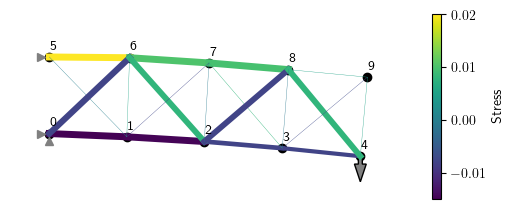

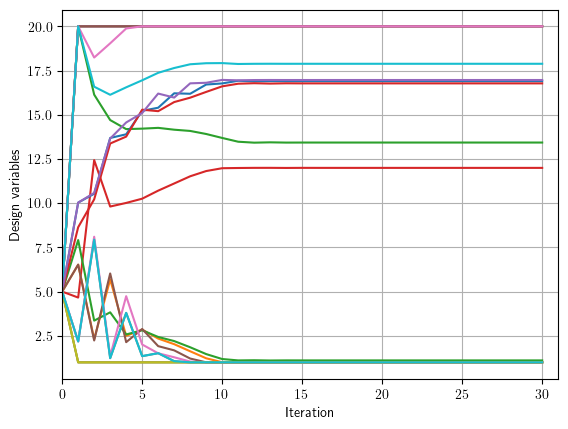

In [34]:
a_0 = 5.0 * torch.ones((len(truss_sample.elements)))
a_min = 1.0 * torch.ones_like(a_0)
a_max = 20.0 * torch.ones_like(a_0)
# Compute volume restriction
l = truss_sample.element_lengths()
V0 = 0.5 * torch.inner(a_max, l)

a_opt = optimize(truss_sample, a_0, a_min, a_max, V0, iter=30)
u, f, sigma = truss_sample.solve(a_opt[-1])
truss_sample.plot(u=u, sigma=sigma, a=a_opt[-1])
plt.savefig("figures/truss_sample_optimized.pdf", transparent=True, bbox_inches="tight")
plt.show()

# plt.rcParams["text.usetex"] = True

plt.plot(range(len(a_opt)), torch.stack(a_opt))
plt.xlabel("Iteration")
plt.ylabel("Design variables")
plt.xlim([0, len(a_opt)])
plt.grid()
# plt.savefig("figures/truss_sample_variables.pdf", transparent=True)
plt.show()


## A large truss system with 136 elements

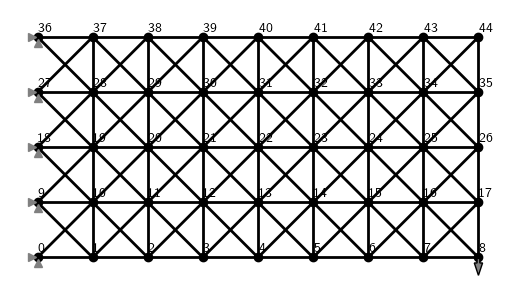

In [35]:
A = 9
B = 5
n1 = torch.linspace(0.0, A - 1.0, A)
n2 = torch.linspace(0.0, B - 1.0, B)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

elem = []
for i in range(A - 1):
    for j in range(B):
        elem.append([i + j * A, i + 1 + j * A])
for i in range(A - 1):
    for j in range(B - 1):
        elem.append([i + 1 + j * A, i + 1 + A + j * A])
for i in range(A - 1):
    for j in range(B - 1):
        elem.append([i + j * A, i + 1 + A + j * A])
        elem.append([i + 1 + j * A, i + A + j * A])

elements = torch.tensor(elem)

forces = torch.zeros_like(nodes)
forces[A - 1, 1] = -0.1
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0, 0] = True
constraints[0, 1] = True
for i in range(B):
    constraints[i * A, 0] = True
    constraints[i * A, 1] = True

large_truss = Truss(nodes, elements, forces, constraints, E=100.0)
large_truss.plot()
plt.savefig("figures/large_truss.pdf", transparent=True, bbox_inches="tight")


## Optimization

Iteration k=0 - Compliance: 0.00018
Iteration k=1 - Compliance: 0.00030
Iteration k=2 - Compliance: 0.00037
Iteration k=3 - Compliance: 0.00121
Iteration k=4 - Compliance: 0.00038
Iteration k=5 - Compliance: 0.00032
Iteration k=6 - Compliance: 0.00132
Iteration k=7 - Compliance: 0.00033
Iteration k=8 - Compliance: 0.00037
Iteration k=9 - Compliance: 0.00095
Iteration k=10 - Compliance: 0.00033
Iteration k=11 - Compliance: 0.00053
Iteration k=12 - Compliance: 0.00054
Iteration k=13 - Compliance: 0.00060
Iteration k=14 - Compliance: 0.00026
Iteration k=15 - Compliance: 0.00034
Iteration k=16 - Compliance: 0.00039
Iteration k=17 - Compliance: 0.00057
Iteration k=18 - Compliance: 0.00032
Iteration k=19 - Compliance: 0.00030
Iteration k=20 - Compliance: 0.00039
Iteration k=21 - Compliance: 0.00043
Iteration k=22 - Compliance: 0.00029
Iteration k=23 - Compliance: 0.00029
Iteration k=24 - Compliance: 0.00029
Iteration k=25 - Compliance: 0.00029
Iteration k=26 - Compliance: 0.00032
Iteration k

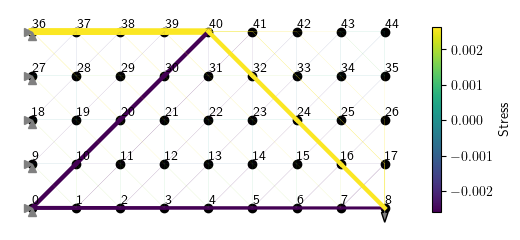

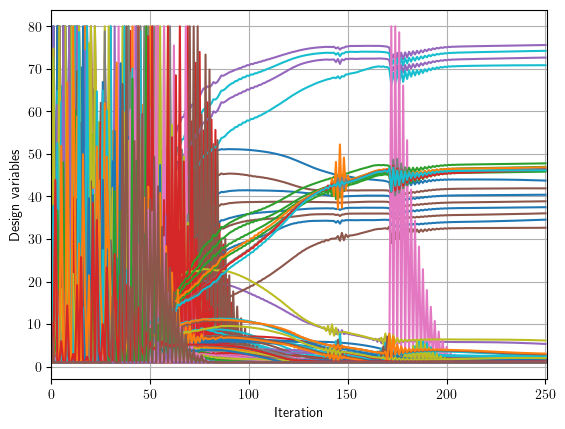

In [36]:
a_0 = 10.0 * torch.ones((len(large_truss.elements)))
a_min = 1.0 * torch.ones_like(a_0)
a_max = 80.0 * torch.ones_like(a_0)
l = large_truss.element_lengths()
V0 = 0.1 * torch.inner(a_max, l)

a_opt = optimize(large_truss, a_0, a_min, a_max, V0, iter=250, s=0.9)
u, f, sigma = large_truss.solve(a_opt[-1])
large_truss.plot(u=u, sigma=sigma, a=a_opt[-1])
plt.savefig("figures/large_truss_optimized.pdf", transparent=True, bbox_inches="tight")
plt.show()

plt.plot(range(len(a_opt)), torch.stack(a_opt))
plt.xlabel("Iteration")
plt.ylabel("Design variables")
plt.xlim([0, len(a_opt)])
plt.grid()
plt.show()
